# Uncertainty Regression


The basic assumption of regression with standard loss function is homoskedasticity, ie, the variance at each measurement is a constant. In reality, it's usually not the case -- the spread of the target can vary along the domain. We call it heteroskedasticity.

In this notebook, we will study how to take heteroskedascity into consideration when doing non-parametric regression.

### Creating the dataset

In [11]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)

gpu-4-culture-plate-sm  Thu Jul 25 07:03:18 2019
[0] GeForce GTX 1080 | 58'C,  46 % |  1495 /  8114 MB | azlokapa(1485M)
[1] GeForce GTX 1080 | 64'C,  46 % |  1427 /  8114 MB | azlokapa(1417M)
[2] GeForce GTX 1080 | 59'C,  46 % |  1427 /  8114 MB | azlokapa(1417M)
[3] GeForce GTX 1080 | 34'C,   0 % |  7561 /  8114 MB | thong(7551M)
[4] GeForce GTX 1080 | 57'C,  39 % |  1427 /  8114 MB | azlokapa(1417M)
[5] GeForce GTX 1080 | 63'C,  47 % |  1421 /  8114 MB | azlokapa(1411M)
[6] GeForce GTX 1080 | 55'C,  38 % |  5234 /  8114 MB | thong(3807M) azlokapa(1417M)
[7] GeForce GTX 1080 | 57'C,  35 % |  1427 /  8114 MB | azlokapa(1417M)


/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/nfshome/thong/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Number of data points:  20000


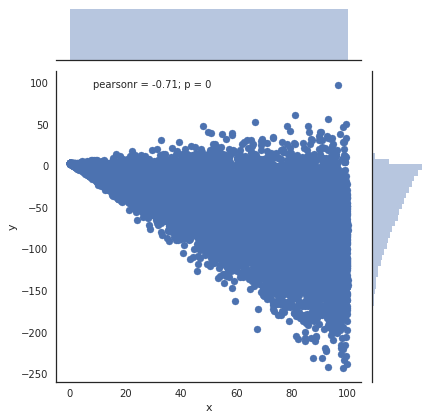

In [107]:
x = np.arange(100, step=0.005)
y = 3-2*x + np.random.normal(x, x/2)
yval = 3-2*x + np.random.normal(x, x/2)
data = pd.DataFrame({'x':x, 'y':y, 'yval': yval})
sns.jointplot(x="x", y="y", data=data)

# Shuffle the dataset for training
idx = np.arange(len(x))
np.random.shuffle(idx)
x_train = x[idx]
y_train = y[idx]
y_trainval = yval[idx]
print("Number of data points: ", len(x))

$x$ is an uniform distribution and $y$ is similar to a log-norm distribution. $p(y|x)$ is a sum of a Gaussian and a linear function.

### MSE Regressor

In [82]:
inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
hidden = Dense(1000, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss='mse', optimizer='adam')
model.summary()

model.fit(x_train,y_train,  epochs=100, batch_size=100, verbose=1, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
          validation_data=(x,yval))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_74 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_75 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 20000 samples
Epoch 1/100
20000/20000 [==============================] - 2s 84us/step - loss: 889.9245 - val_loss: 844.8299
Epoch 2/100
20000/20000 [==============================] - 1s 47us/step - loss: 850.9875 - val_loss: 834

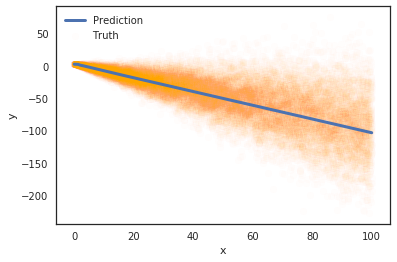

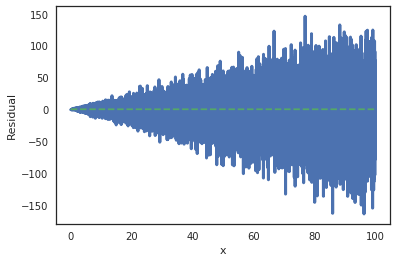

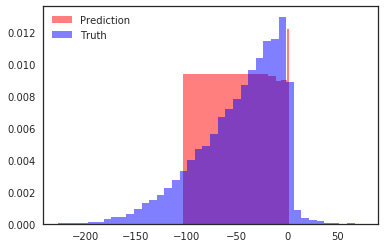

In [84]:
yhat = model.predict(x)
plt.plot(x,yhat, linewidth=3, label='Prediction')
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.01)
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
res_y = yhat.flatten()-yval
plt.plot(x, res_y, linewidth=3)
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.show()

plt.figure()
plt.hist(yhat,  bins=40, color='red', alpha=0.5, label='Prediction', density=True)
plt.hist(yval, color='blue', bins=40, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

As we can see from the first and second plots, a simple regression with MSE loss function is good enough for doing a fit that predicts the conditional mean $(y|x)$. However, the marginal distribution $p(y)$ itself is quite off, from the bottom plot. We also can't quantify the uncertainty of the prediction -- how to do this? 

One approach is to reparametrize the output prediction of each point into a pdf $N(\mu, \sigma)$ and maximize its likelihood given the input data. 

### Gaussian Regressor

In [17]:
def InverseSquareRootLinearUnit(args, min_value = 5e-5):
    return 1. + min_value + K.tf.where(K.tf.greater(args, 0), args, K.tf.divide(args, K.sqrt(1.+K.square(args))))

def gauss_loss(y_true, y_pred):
    mu = y_pred[:,0]
    sigma = y_pred[:,1]
    norm_x = K.tf.divide(y_true - mu, sigma)
    single_NLL = K.log(sigma) + 0.5*K.square(norm_x)
    return K.sum(single_NLL, axis=-1)

def sum_of_gaussians(x, mu_vec, sigma_vec):
    # x: numpy array of the bin centers
    x = np.atleast_2d(x)
    if x.shape[0] <= x.shape[1]:
        x = x.T
    x_norm = (x - mu_vec)/sigma_vec
    single_gaus_val = np.exp(-0.5*np.square(x_norm))/(sigma_vec*np.sqrt(2*np.pi))
    return np.sum(single_gaus_val, axis=1)/mu_vec.shape[0]

In [73]:
inputs = Input(shape=(1,))
hidden = Dense(1000)(inputs)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model_ordered = Model(inputs, output)
Gaussian_model_ordered.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model_ordered.summary()

# x, y are unshuffled, where x increasing monotonically from 0 to 100.
Gaussian_model_ordered.fit(x, y,
            validation_data=(x,yval),
            epochs=500, batch_size=10, verbose=1, shuffle=False,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
          )



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_67 (Dense)                (None, 1000)         2000        input_24[0][0]                   
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 1)            1001        dense_67[0][0]                   
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 1)            1001        dense_67[0][0]                   
__________________________________________________________________________________________________
lambda_17 

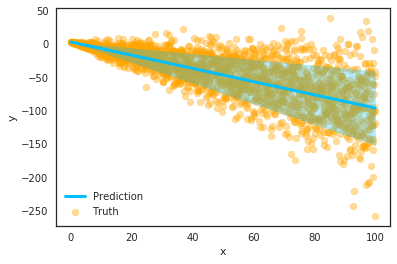

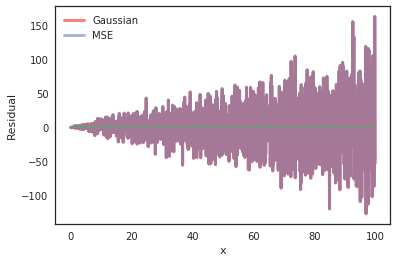

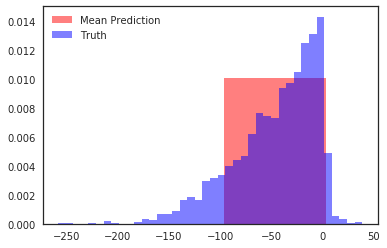

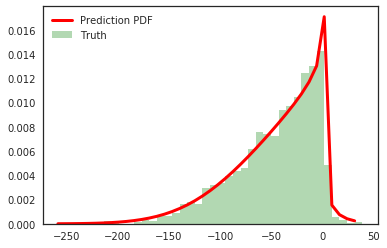

In [74]:
y_gauss = Gaussian_model_ordered.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth', alpha=0.4)
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.3, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, color='red', linewidth=3, alpha=0.5, label='Gaussian')
plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

N_bins = 40

plt.figure()
plt.hist(y_gauss_mean,  bins=N_bins, color='red', alpha=0.5, label='Mean Prediction', density=True)
plt.hist(yval, color='blue', bins=N_bins, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, y_gauss_mean, y_gauss_var)
plt.figure()
plt.plot(z,bin_content, linewidth=3, color='red', label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

So far so good: the Guassian model can capture the mean and sigma of the dataset and perfectly reconstruct the marginal distribution $p(y)$. 

HOWEVER, there is one huge catch: in the training above I deliberately use unshuffled data, ie, $x$ is a monotonically increasing function. If I use the shuffled $x_{train}, y_{train}$ instead, one would expect nothing change. This is when surprise comes:

In [76]:
inputs = Input(shape=(1,))
hidden = Dense(1000,activation='relu')(inputs)
hidden = Dense(500, activation='relu')(hidden)
output_mu = Dense(1)(hidden)
output_sigma = Dense(1)(hidden)
output_sigma = Lambda(InverseSquareRootLinearUnit)(output_sigma)
output = Concatenate(axis=-1)([output_mu, output_sigma])
Gaussian_model = Model(inputs, output)
Gaussian_model.compile(loss=gauss_loss, optimizer='adam')
Gaussian_model.summary()

# x_train, y_train were shuffled in unison.
Gaussian_model.fit(x_train, y_train,  epochs=500, batch_size=10, verbose=1, 
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                  validation_data=(x_train, y_trainval))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 1000)         2000        input_25[0][0]                   
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 500)          500500      dense_70[0][0]                   
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 1)            501         dense_71[0][0]                   
__________________________________________________________________________________________________
dense_72 (

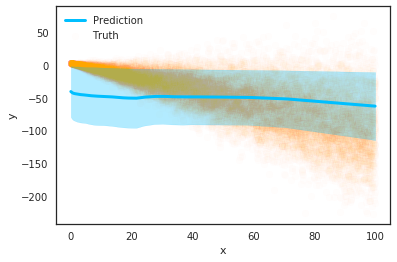

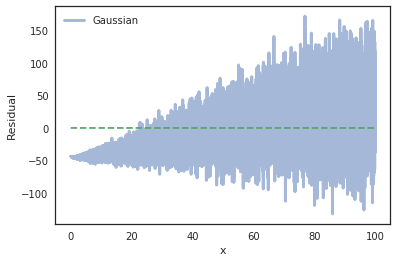

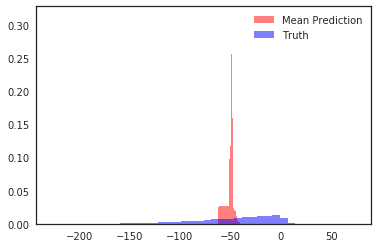

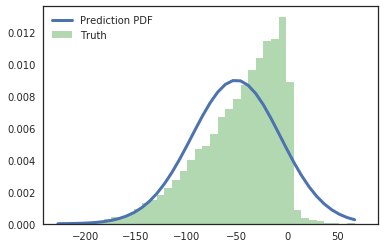

In [81]:
y_gauss = Gaussian_model.predict(x)
y_gauss_mean = y_gauss[:,0]
y_gauss_var = y_gauss[:,1]

plt.scatter(x,yval, color='orange', label='Truth', alpha=0.01)
plt.plot(x,y_gauss_mean, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, y_gauss_mean-y_gauss_var,y_gauss_mean+y_gauss_var, alpha=0.3, color='deepskyblue')


plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

plt.figure()
res_ygauss = y_gauss_mean.flatten()-yval
plt.plot(x, res_ygauss, linewidth=3, alpha=0.5, label='Gaussian')
#plt.plot(x, res_y, linewidth=3, alpha=0.5, label='MSE')
plt.plot(x,0*x, '--')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend(loc='best')
plt.show()

N_bins = 40

plt.figure()
plt.hist(y_gauss_mean,  bins=N_bins, color='red', alpha=0.5, label='Mean Prediction', density=True)
plt.hist(yval, color='blue', bins=N_bins, alpha=0.5, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, y_gauss_mean, y_gauss_var)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

This method doesn't work.

I dig through literature a bit to see how statisticans do this. The solution seems quite simple: They use one neural net to estimate the mean and another one to estimate the residual. Let's try:

## Estimate the spread in a separated network

In [88]:
# For the model that estimate the mean, I reuse the MSE model above.
# Now I'm gonna build the model that estimate the variance

log_var = np.log(np.square(res_y))
log_var_train = log_var[idx]

inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
output = Dense(1)(hidden)

sigma_model = Model(inputs, output)
sigma_model.compile(loss='mse', optimizer='adam')
sigma_model.summary()

sigma_model.fit(x_train, log_var_train,
            epochs=40, batch_size=100, verbose=1
          )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 1001      
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
20000/20000 [==============================] - 1s 66us/step - loss: 6.6321
Epoch 2/40
20000/20000 [==============================] - 1s 30us/step - loss: 5.6449
Epoch 3/40
20000/20000 [==============================] - 1s 30us/step - loss: 5.5520
Epoch 4/40
20000/20000 [==============================] - 1s 29us/step - loss: 5.4602
Epoch 5/40
20000/20000 [==============================] - 1s

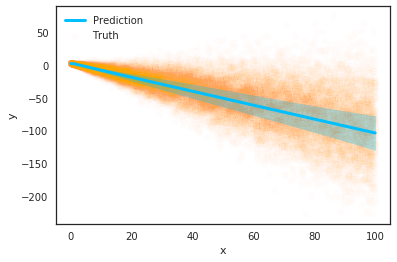

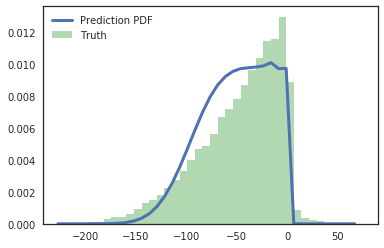

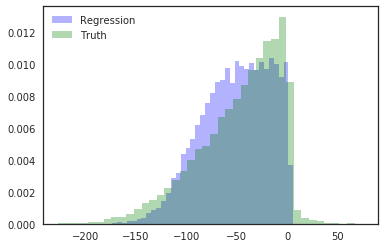

In [89]:
log_var_pred = sigma_model.predict(x)
std_pred = np.sqrt(np.exp(log_var_pred)).flatten()
yhat = yhat.flatten()
plt.scatter(x,yval, color='orange', label='Truth', alpha=0.01)
plt.plot(x, yhat, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, yhat-std_pred, yhat+std_pred, alpha=0.3, color='deepskyblue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

N_bins = 40

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
bin_content = sum_of_gaussians(z, yhat, std_pred)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

# Sample from predict PDF to get a new dataset
yregressed = yhat + np.random.normal(0, std_pred)
plt.figure()
plt.hist(yregressed, color='blue', bins=N_bins, alpha=0.3, label='Regression', density=True)
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()


It's not perfect, but much better! Now how about doing quantile regression for this std instead?

In [101]:
def quantile_loss(true, pred):
    alpha = 0.841 # 84.1 - 50 = 34.1 = 1 sigma away from the mean
    err = true-pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)
inputs = Input(shape=(1,))
hidden = Dense(1000, activation='relu')(inputs)
output = Dense(1)(hidden)

quantile_model = Model(inputs, output)
quantile_model.compile(loss=quantile_loss, optimizer='adam')
quantile_model.summary()

quantile_model.fit(x_train, y_train,
            epochs=50, batch_size=100, verbose=1
          )



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_93 (Dense)             (None, 1000)              2000      
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 1001      
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20000/20000 [==============================] - 1s 70us/step - loss: 6.1891
Epoch 2/50
20000/20000 [==============================] - 1s 28us/step - loss: 6.0820
Epoch 3/50
20000/20000 [==============================] - 1s 29us/step - loss: 6.0658
Epoch 4/50
20000/20000 [==============================] - 1s 29us/step - loss: 6.0629
Epoch 5/50
20000/20000 [==============================] - 1s

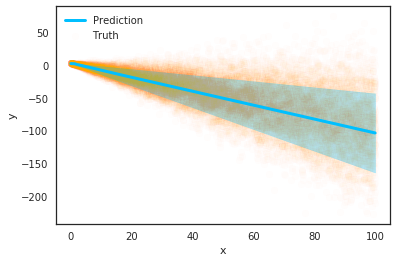

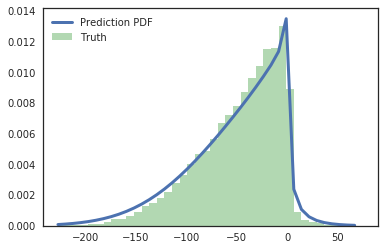

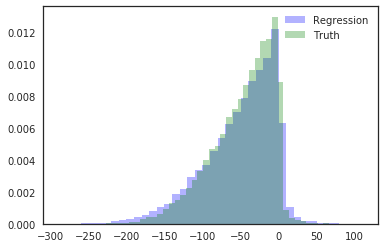

In [103]:
upper_bound = quantile_model.predict(x).flatten()

plt.scatter(x,yval, color='orange', label='Truth', alpha=0.01)
plt.plot(x, yhat, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, 2*yhat-upper_bound, upper_bound, alpha=0.3, color='deepskyblue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

N_bins = 40

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
std_pred = upper_bound-yhat
bin_content = sum_of_gaussians(z, yhat, std_pred)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

# Sample from predict PDF to get a new dataset
yregressed = yhat + np.random.normal(0, np.absolute(std_pred))
plt.figure()
plt.hist(yregressed, color='blue', bins=N_bins, alpha=0.3, label='Regression', density=True)
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()


Perfecto!

Can we combine these 2 networks into 1? Now I'm gonna switch to PyTorch because it's easier to handle complex loss functions:

In [151]:
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

def custom_loss(y_true, y_pred):
    y_mean = y_pred[:,0].unsqueeze(1)
    y_upperbound = y_pred[:,1].unsqueeze(1)
    loss_mean = torch.abs(y_true - y_mean)
    alpha = 0.841
    err = y_true - y_upperbound
    loss_ub = (err >= 0).float()*alpha*err + (err < 0).float()*(alpha-1)*err
    return torch.mean(torch.mean((loss_mean + loss_ub), -1), -1)
    
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.xdata = torch.from_numpy(xdata).float()
        self.ydata = torch.from_numpy(ydata).float()

    def __len__(self):
        return len(self.xdata)

    def __getitem__(self, idx):
        return self.xdata[idx], self.ydata[idx]
    
train_data = MyDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)

for t in range(10):
    batch_loss =  []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(Variable(xtrain.unsqueeze(1).float().cuda()))
        label = Variable(ytrain.float()).cuda()
        
        # Compute and print loss.
        loss = custom_loss(label.unsqueeze(1), y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    print("Epoch {}: Loss: {}.".format(t, loss.data[0]))


Epoch 0: Loss: 26.162668228149414.
Epoch 1: Loss: 28.562461853027344.
Epoch 2: Loss: 25.904191970825195.
Epoch 3: Loss: 22.53019142150879.
Epoch 4: Loss: 19.680177688598633.
Epoch 5: Loss: 23.690412521362305.
Epoch 6: Loss: 29.390560150146484.
Epoch 7: Loss: 23.06656265258789.
Epoch 8: Loss: 21.59811782836914.
Epoch 9: Loss: 29.303850173950195.


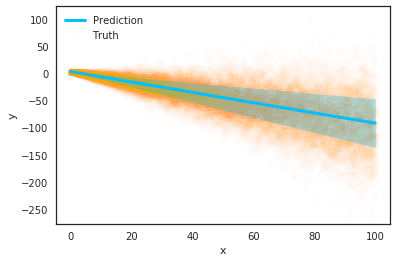

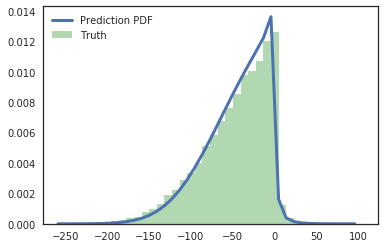

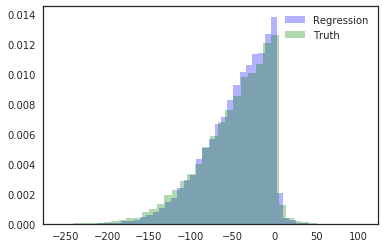

In [150]:
pred = model(Variable(torch.from_numpy(x).unsqueeze(1).float().cuda()))
yhat = pred[:,0].data.cpu().numpy()
upper_bound = pred[:,1].data.cpu().numpy()

plt.scatter(x, yval, color='orange', label='Truth', alpha=0.01)
plt.plot(x, yhat, linewidth=3, color='deepskyblue', label='Prediction')
plt.fill_between(x, 2*yhat-upper_bound, upper_bound, alpha=0.3, color='deepskyblue')

plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

N_bins = 40

l_bound = min(yval)
u_bound = max(yval)
bin_width = (u_bound - l_bound)/N_bins
z = np.arange(l_bound, u_bound, bin_width)
std_pred = upper_bound-yhat
bin_content = sum_of_gaussians(z, yhat, std_pred)
plt.figure()
plt.plot(z,bin_content, linewidth=3, label='Prediction PDF')
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()

# Sample from predict PDF to get a new dataset
yregressed = yhat + np.random.normal(0, np.absolute(std_pred))
plt.figure()
plt.hist(yregressed, color='blue', bins=N_bins, alpha=0.3, label='Regression', density=True)
plt.hist(yval, color='green', bins=N_bins, alpha=0.3, label='Truth', density=True)
plt.legend(loc='best')
plt.show()


### Takeaway messages
- MSE is good as a deterministic fit -- but to reconstruct the full marginal distribution, you need to go further.
- Don't worry about overfitting if the training data sufficiently covers the whole phase space. "Too many parameters will overfit" is a myth in deep neural network -- as long as you use minibatch it's a regularization itself.
- Parametrize the output to estimate the PDF only works under certain conditions.
- Traditional method using 2 separated networks to estimate the mean and sigma seems to be the most reliable. One can sample from these distributions to get a regressed dataset that closely resemble the target data.
- With a neural network, we can also estimate the mean and sigma directly using quantile regression for sigma.